# Metodología de Control de Calidad e Imputación de Datos de Series de Precipitación In Situ

## Objetivo
Esta metodología tiene como finalidad establecer un proceso robusto para la imputación de datos de precipitación in situ, utilizando técnicas modernas de Big Data y Machine Learning, complementadas con datos satelitales y bases de datos climáticas globales (como CHIRPS, ERA5, entre otras).

## 1. Preprocesamiento y Estandarización de Datos
Antes de aplicar cualquier proceso de control de calidad o imputación, es fundamental garantizar la correcta estructuración de los datos brutos o primarios.

La estructura base de una serie de datos estandarizada será:

| Index       | value |
|-------------|--------|
| 2020-01-01  | 2.53   |

- Index: tipo datetime, correspondiente a la fecha y hora de la observación.

- value: valor numérico registrado (precipitación en mm, por ejemplo).

Esta estructura debe representarse como una `pandas.Series` o un `pandas.DataFrame`, con índice tipo `datetime`.

## 2. Estructura de Control de Calidad
A partir de la serie estandarizada, se genera una estructura de control de calidad que enriquece la serie con metadatos asociados al resultado de las pruebas de calidad:

| Index       | value | qf | dp    |
|-------------|-------|----|-------|
| 2020-01-01  | 2.53  | 1  | 22358 |

- **qf (Quality Flag)**: código numérico que indica el resultado de una o varias pruebas de calidad.

- **dp (Descriptor de Proceso)**: identificador del proceso o técnica aplicada (detección, interpolación, imputación, etc.).

> ⚠️ La preservación de los datos originales es una prioridad. Las modificaciones solo deben aplicarse cuando la prueba indique una necesidad clara y bien justificada.

## 3. Pruebas de Control de Calidad
### 3.1. Consistencia Temporal
Una serie temporal debe tener frecuencia de muestreo constante. Esto significa que cada paso de tiempo entre observaciones debe ser homogéneo (e.g., diaria, horaria).

Proceso:
- Se analiza la frecuencia de muestreo mediante pandas.infer_freq o análisis de diferencias del índice.

- Si se detectan huecos en la serie (días u horas faltantes), se reindexa la serie para completar la malla temporal esperada.

    `df = df.asfreq('D')  # ejemplo para series diarias`
- A los puntos sin datos se les asigna un valor por defecto de -99999, conforme a estándares internacionales como los del IODE (International Oceanographic Data and Information Exchange).
    `df['value'].fillna(-99999, inplace=True)`

### 3.2. Otras Pruebas Básicas
- Rango Físico Aceptable: verifica que los valores estén dentro del rango físico o esperable (e.g., precipitación no puede ser negativa).

- Detección de valores extremos/anómalos: puede utilizarse el IQR, desviaciones estándar, o algoritmos robustos como Isolation Forest.

- Duplicados temporales: detección y resolución de registros con el mismo timestamp.

- Coherencia contextual: análisis de coherencia con estaciones vecinas o datos satelitales.

## 4. Imputación de Datos Faltantes
Una vez aplicada la batería de pruebas de calidad y etiquetados los valores anómalos o faltantes, se procede con la imputación de datos.

### 4.1. Fuentes de Información para la Imputación
- Estaciones vecinas (in situ).

- Datos satelitales (e.g., CHIRPS, GPM).

- Reanálisis climáticos (e.g., ERA5).

- Modelos estadísticos o de machine learning.

### 4.2. Técnicas de Imputación
- Interpolación temporal: lineal, spline, polinómica.

- K-Nearest Neighbors (KNN).

- Modelos de regresión multivariable (MLR).

- Redes neuronales (RNN, LSTM) para imputaciones complejas.

- Random Forest para variables con relaciones no lineales.

- La técnica aplicada se documenta en la columna dp, permitiendo rastrear el origen de cada dato imputado.

## 5. Estándares y Buenas Prácticas
- Trazabilidad: Toda modificación o imputación debe estar documentada y trazable.

- Conservación de Datos Originales: Mantener una copia sin modificar de la serie original.

- Reproducibilidad: Los scripts de calidad deben ser modulares y versionados.

- Evaluación Continua: Los algoritmos de imputación deben ser validados periódicamente frente a nuevas entradas de datos.

```
import pandas as pd

# Serie original
data = {'value': [2.53, 3.0, None, 2.1]}
index = pd.date_range(start='2020-01-01', periods=4, freq='D')
df = pd.DataFrame(data, index=index)

# Estructura de calidad
df['qf'] = [1, 1, 9, 1]  # 9 indica dato faltante
df['dp'] = [22358, 22358, 99999, 22358]
```
7. Resultados Esperados
- Series de precipitación limpias, consistentes, completas y trazables.

- Imputaciones realizadas con soporte técnico y científico.

- Alineación con estándares internacionales (WMO, IODE, etc.).

- Base sólida para análisis hidrometeorológicos, climatológicos o de gestión del recurso hídrico.



# Serie (redmpomm) Somo

In [46]:
from api_somo import APIClient, fetch_qf 
import logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Configuración del logger
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

api_url = "http://127.0.0.1:8000/database/functions/time-series/filter_date_serie/"
params = {
    "station_name": "tumaco",
    "variable_name": "Precipitación acumulada",
    "processing_level_name": "Control de calidad",
    "start_date": "2009-01-01",
    "end_date": "2023-12-31"
}

try:
    # 1. Solicitar y procesar los datos
    red_mpomm_serie, red_mpomm_metadata = APIClient.fetch_and_process_data(api_url, params)

    # Asegurar que el índice es datetime
    if not pd.api.types.is_datetime64_any_dtype(red_mpomm_serie.index):
        red_mpomm_serie.index = pd.to_datetime(red_mpomm_serie.index)

    if red_mpomm_serie.empty:
        raise ValueError("La serie histórica está vacía.")

    #logger.info(f"Serie histórica descargada correctamente. Columnas: {red_mpomm_serie.columns.tolist()}")

except Exception as e:
    logger.error(f"Error al obtener la serie histórica: {e}")
    red_mpomm_serie = pd.DataFrame()  # para evitar errores en siguientes pasos

# --- PROCESAMIENTO: FILTRAR CALIDAD ---
if not red_mpomm_serie.empty:
    # QF: Solo valores con calidad 1 o 3 son aceptados
    red_mpomm_serie.loc[~red_mpomm_serie['qf'].isin([1])] = np.nan
    red_mpomm_serie = red_mpomm_serie.drop(columns='qf')

    # Reporte de NaNs
    print('Reporte de datos NaN por columna:')
    print(red_mpomm_serie.isnull().sum())

    # Mostrar primeras filas
    red_mpomm_serie

INFO:api_somo:Sending request to http://127.0.0.1:8000/database/functions/time-series/filter_date_serie/ with parameters: {'station_name': 'tumaco', 'variable_name': 'Precipitación acumulada', 'processing_level_name': 'Control de calidad', 'start_date': '2009-01-01', 'end_date': '2023-12-31'}
INFO:api_somo:Original columns: ['date_time', 'sensor_data', 'quality_flag']
INFO:api_somo:Timestamp conversion and indexing complete.


Reporte de datos NaN por columna:
value    29772
dtype: int64


## Prerocesamiento serie redmpomm

En esta etapa se realiza un remuestreo de la serie a 3h ya que las series de apoyo que se utilizaran para el desarrollo de esta metodologia tienen una resolucion maxima de 3h, para esto tomamos una condicion en nustre serie la cual para ser sonsiderado el balor remuestreado debe contener mas del **80%** de los datos buenos, en el caso contrario dejara este espacio como un NaN
 

Reporte de datos NaN y/o null en la serie actual: 
value    1848
dtype: int64 



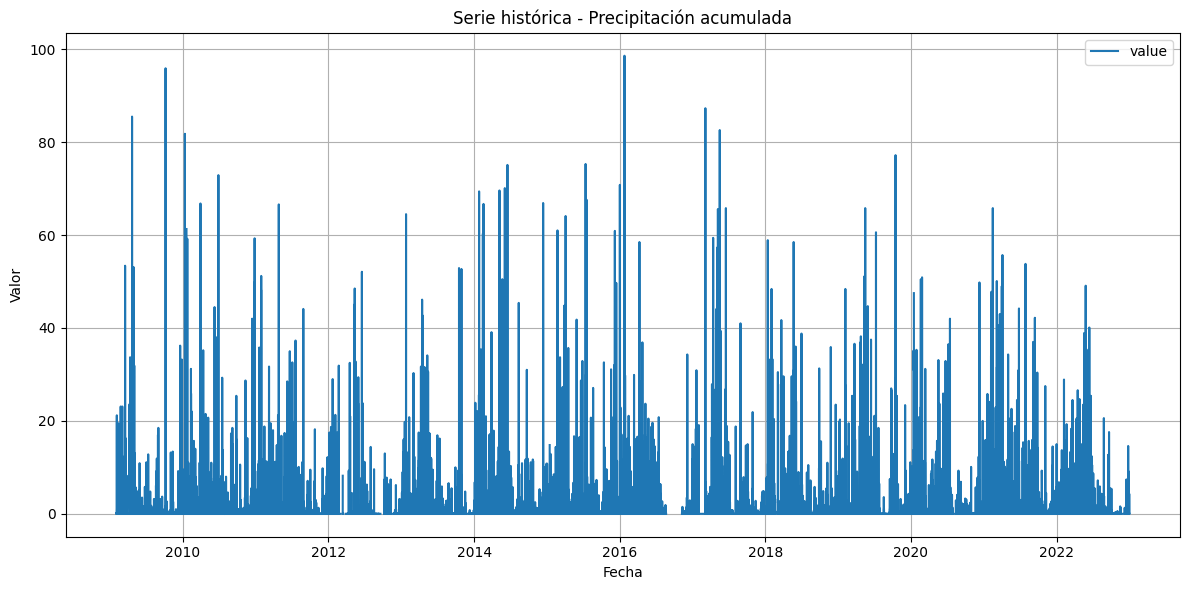

In [47]:
# Remuestreo condicional

# Función para eliminar grupos con más de un porcentaje de NaN
def custom_resample(group, nan_threshold=0.2):
    nan_ratio = group.isna().sum() / len(group)
    return group.sum() if nan_ratio < nan_threshold else np.nan

# Resampleo con diferentes períodos de agregación
red_mpomm_serie_3h = red_mpomm_serie.resample('3h').apply(lambda g: custom_resample(g, nan_threshold=0.2))
print('Reporte de datos NaN y/o null en la serie actual: ')
print(red_mpomm_serie_3h.isnull().sum(),'\n')

lower_bound = 0
upper_bound = 100
# Reemplazar outliers con NaN
red_mpomm_serie_3h['value'] = red_mpomm_serie_3h['value'].where((red_mpomm_serie_3h['value'] >= lower_bound) & (red_mpomm_serie_3h['value'] <= upper_bound), np.nan)

# --- GRAFICAR ---
plt.figure(figsize=(12, 6))
plt.plot(red_mpomm_serie_3h, label=red_mpomm_serie_3h.columns[0])
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.title('Serie histórica - Precipitación acumulada')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Serie MSWEB

Se realiza la obtencion de la matriz de datos de la base de datos global y se maneja los datos ausentes

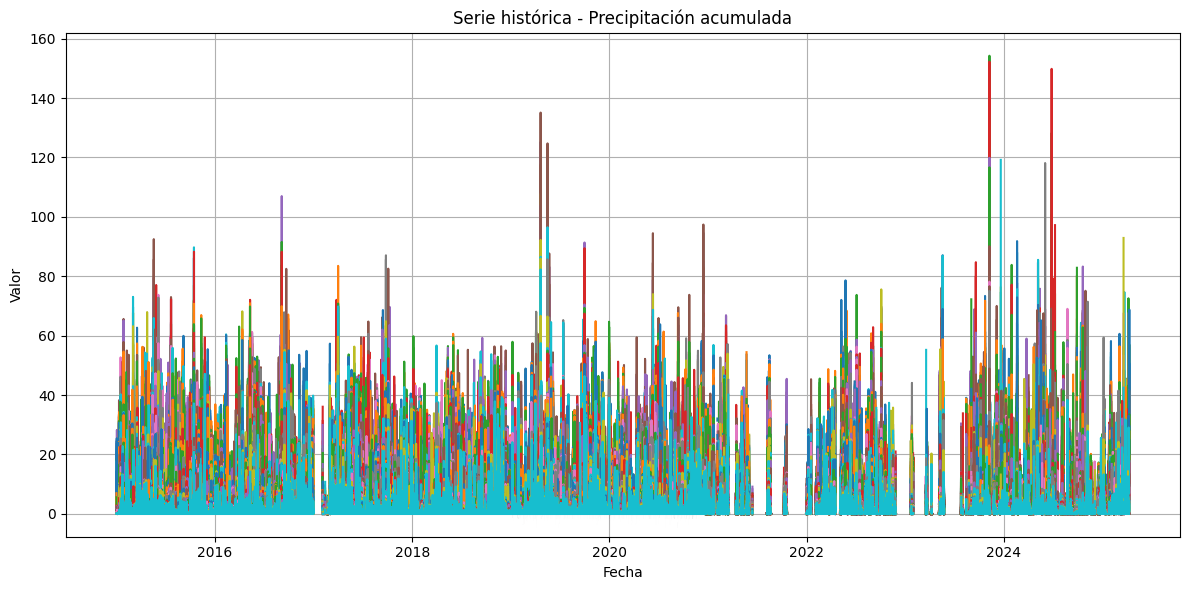

Reporte de datos NaN por columna:
lat_3.25_lon_-80.15    6392
lat_3.25_lon_-80.05    6392
lat_3.25_lon_-79.95    6392
lat_3.25_lon_-79.85    6392
lat_3.25_lon_-79.75    6392
                       ... 
lat_0.35_lon_-77.65    6392
lat_0.35_lon_-77.55    6392
lat_0.35_lon_-77.45    6392
lat_0.35_lon_-77.35    6392
lat_0.35_lon_-77.25    6392
Length: 900, dtype: int64


lat_3.25_lon_-80.15  lat_3.25_lon_-80.05  \
2015-01-01 00:00:00             1.000000             0.812500   
2015-01-01 03:00:00             0.375000             0.437500   
2015-01-01 06:00:00             0.250000             0.250000   
2015-01-01 09:00:00             0.312500             0.062500   
2015-01-01 12:00:00             0.750000             0.812500   
...                                  ...                  ...   
2025-04-10 03:00:00             1.130761             1.393022   
2025-04-10 06:00:00             1.195451             1.070038   
2025-04-10 09:00:00             0.167510             0.319612   
2025-04-10 12:00:00             2.754207             3.251528   
2025-04-10 15:00:00             1.619769             1.127022   

                     lat_3.25_lon_-79.95  lat_3.25_lon_-79.85  \
2015-01-01 00:00:00             0.437500             0.187500   
2015-01-01 03:00:00             0.250000             0.687500   
2015-01-01 06:00:00             0.687500             1.250000   
2015-01-01 09:00:00             0.062500             0.000000   
2015-01-01 12:00:00             0.812500             0.750000   
...                                  ...                  ...   
2025-04-10 03:00:00             1.356753             2.018488   
2025-04-10 06:00:00             1.045172             1.023405   
2025-04-10 09:00:00             0.306421             0.157334   
2025-04-10 12:00:00             4.775580             4.134336   
2025-04-10 15:00:00             1.109923             0.733727   

                     lat_3.25_lon_-79.75  lat_3.25_lon_-79.65  \
2015-01-01 00:00:00             0.187500             0.187500   
2015-01-01 03:00:00             1.062500             1.250000   
2015-01-01 06:00:00             1.250000             0.437500   
2015-01-01 09:00:00             0.000000             0.000000   
2015-01-01 12:00:00             0.750000             0.812500   
...                                  ...                  ...   
2025-04-10 03:00:00             1.988187             2.017505   
2025-04-10 06:00:00             1.029268             1.071232   
2025-04-10 09:00:00             0.157339             0.279948   
2025-04-10 12:00:00             3.978819             4.296918   
2025-04-10 15:00:00             0.756578             0.792208   

                     lat_3.25_lon_-79.55  lat_3.25_lon_-79.45  \
2015-01-01 00:00:00             0.187500             0.187500   
2015-01-01 03:00:00             1.500000             1.062500   
2015-01-01 06:00:00             0.750000             0.687500   
2015-01-01 09:00:00             0.000000             0.000000   
2015-01-01 12:00:00             0.875000             0.875000   
...                                  ...                  ...   
2025-04-10 03:00:00             2.438898             2.401794   
2025-04-10 06:00:00             1.259671             1.392551   
2025-04-10 09:00:00             0.689413             0.689083   
2025-04-10 12:00:00             5.841646             7.203510   
2025-04-10 15:00:00             0.529317             0.516464   

                     lat_3.25_lon_-79.35  lat_3.25_lon_-79.25  ...  \
2015-01-01 00:00:00             0.187500             0.187500  ...   
2015-01-01 03:00:00             0.812500             0.750000  ...   
2015-01-01 06:00:00             0.687500             0.687500  ...   
2015-01-01 09:00:00             0.000000             0.000000  ...   
2015-01-01 12:00:00             0.812500             0.812500  ...   
...                                  ...                  ...  ...   
2025-04-10 03:00:00             2.480694             2.459767  ...   
2025-04-10 06:00:00             1.301603             1.140934  ...   
2025-04-10 09:00:00             1.050254             1.096370  ...   
2025-04-10 12:00:00            10.714794            10.262192  ...   
2025-04-10 15:00:00             0.997060             1.028062  ...   

                     lat_0.35_lon_-78.15  lat_0.35_lon_-

In [48]:
import pandas as pd

# Cargar el CSV y parsear la columna de fecha como datetime
msweb_serie = pd.read_csv(
    r"E:\074-Diego Rengifo 2025\datasience\precipitacion\db\MSWEP-GloH2O\csv-3h\precipitacion tum radius(1.82011, -78.72871).csv",
    parse_dates=['dates'],   # reemplaza 'datetime' con el nombre real de tu columna de fecha
    index_col='dates'        # establecer la columna como índice
)


# --- Preprocesamiento: Agregacion temporal ---
if not msweb_serie.empty:
    msweb_serie.index= pd.to_datetime(msweb_serie.index)

    # Paso 2: Crear una serie con índice completo con frecuencia cada 3 horas
    start = msweb_serie.index.min()
    end = msweb_serie.index.max()
    full_index = pd.date_range(start=start, end=end, freq='3h')

    # Paso 3: Reindexar para insertar NaN donde faltan datos
    msweb_serie_with_nans = msweb_serie.reindex(full_index)
    
    # --- GRAFICAR ---
    plt.figure(figsize=(12, 6))
    plt.plot(msweb_serie_with_nans, label=msweb_serie.columns[0])
    plt.xlabel('Fecha')
    plt.ylabel('Valor')
    plt.title('Serie histórica - Precipitación acumulada')
    plt.grid(True)
    #plt.legend()
    plt.tight_layout()
    plt.show()

    # Reporte de NaNs
print('Reporte de datos NaN por columna:')
print(msweb_serie_with_nans.isnull().sum())
msweb_serie_with_nans



# Dataset

Se realiza la union de la informacion en un dataset, en este añadimos datos de la redmpomm y de la base de datos global, en las marcas de tiempo que coincidan, con el fin de unificar y procesar los datos de manera mas optima.


In [49]:
# Asegurarse de que el índice de todos los DataFrames sea datetime sin zona horaria
msweb_serie.index = pd.to_datetime(msweb_serie.index).tz_localize(None)
red_mpomm_serie_3h.index = pd.to_datetime(red_mpomm_serie_3h.index).tz_localize(None)

# Convertir la serie objetivo en DataFrame si no lo es
serie_red = red_mpomm_serie_3h[['value']].copy()

# Renombrar columnas de msweb_serie con un prefijo claro
msweb_renamed = msweb_serie.copy()
msweb_renamed.columns = [f'precipitation_{i+1}' for i in range(len(msweb_serie.columns))]

# Unir todo en un solo DataFrame usando concat (más eficiente que múltiples joins)
dataset = pd.concat([serie_red, msweb_renamed], axis=1)

# Reporte de NaNs
print('Reporte de datos NaN por columna:')
print(dataset.isnull().sum())

# Mostrar primeras filas
print(dataset.head())


Reporte de datos NaN por columna:
value                 5606
precipitation_1      20783
precipitation_2      20783
precipitation_3      20783
precipitation_4      20783
                     ...  
precipitation_896    20783
precipitation_897    20783
precipitation_898    20783
precipitation_899    20783
precipitation_900    20783
Length: 901, dtype: int64
                     value  precipitation_1  precipitation_2  precipitation_3  \
2009-02-01 03:00:00    0.0              NaN              NaN              NaN   
2009-02-01 06:00:00    0.0              NaN              NaN              NaN   
2009-02-01 09:00:00    0.0              NaN              NaN              NaN   
2009-02-01 12:00:00    0.0              NaN              NaN              NaN   
2009-02-01 15:00:00    0.0              NaN              NaN              NaN   

                     precipitation_4  precipitation_5  precipitation_6  \
2009-02-01 03:00:00              NaN              NaN              NaN   
2009-02-

In [50]:
# Filtrar todas las columnas de precipitación (excluyendo la serie objetivo)
precip_cols = [col for col in dataset.columns if col.startswith('precipitation_')]

# Encontrar el primer índice donde al menos una columna de precipitación tiene un valor no nulo
non_null_mask = dataset[precip_cols].notnull().any(axis=1)
start_index = dataset[non_null_mask].index.min()
end_index = dataset.iloc[:, 0].last_valid_index()

# Filtrar el DataFrame desde ese índice en adelante
filtered_dataset = dataset.loc[start_index:end_index]

# Verificar resultado
print(f"Primer dato válido en al menos una columna de precipitación: {start_index}")
filtered_dataset


Primer dato válido en al menos una columna de precipitación: 2015-01-01 00:00:00


value  precipitation_1  precipitation_2  precipitation_3  \
2015-01-01 00:00:00    0.0           1.0000           0.8125           0.4375   
2015-01-01 03:00:00    0.0           0.3750           0.4375           0.2500   
2015-01-01 06:00:00    0.0           0.2500           0.2500           0.6875   
2015-01-01 09:00:00    0.2           0.3125           0.0625           0.0625   
2015-01-01 12:00:00    4.7           0.7500           0.8125           0.8125   
...                    ...              ...              ...              ...   
2022-12-31 15:00:00    2.0              NaN              NaN              NaN   
2022-12-31 18:00:00    0.1              NaN              NaN              NaN   
2022-12-31 21:00:00    0.0              NaN              NaN              NaN   
2023-01-01 00:00:00    0.0              NaN              NaN              NaN   
2023-01-01 03:00:00    0.0              NaN              NaN              NaN   

                     precipitation_4  precipitation_5  precipitation_6  \
2015-01-01 00:00:00           0.1875           0.1875           0.1875   
2015-01-01 03:00:00           0.6875           1.0625           1.2500   
2015-01-01 06:00:00           1.2500           1.2500           0.4375   
2015-01-01 09:00:00           0.0000           0.0000           0.0000   
2015-01-01 12:00:00           0.7500           0.7500           0.8125   
...                              ...              ...              ...   
2022-12-31 15:00:00              NaN              NaN              NaN   
2022-12-31 18:00:00              NaN              NaN              NaN   
2022-12-31 21:00:00              NaN              NaN              NaN   
2023-01-01 00:00:00              NaN              NaN              NaN   
2023-01-01 03:00:00              NaN              NaN              NaN   

                     precipitation_7  precipitation_8  precipitation_9  ...  \
2015-01-01 00:00:00           0.1875           0.1875           0.1875  ...   
2015-01-01 03:00:00           1.5000           1.0625           0.8125  ...   
2015-01-01 06:00:00           0.7500           0.6875           0.6875  ...   
2015-01-01 09:00:00           0.0000           0.0000           0.0000  ...   
2015-01-01 12:00:00           0.8750           0.8750           0.8125  ...   
...                              ...              ...              ...  ...   
2022-12-31 15:00:00              NaN              NaN              NaN  ...   
2022-12-31 18:00:00              NaN              NaN              NaN  ...   
2022-12-31 21:00:00              NaN              NaN              NaN  ...   
2023-01-01 00:00:00              NaN              NaN              NaN  ...   
2023-01-01 03:00:00              NaN              NaN              NaN  ...   

                     precipitation_891  precipitation_892  precipitation_893  \
2015-01-01 00:00:00                0.0                0.0                0.0   
2015-01-01 03:00:00                0.0                0.0                0.0   
2015-01-01 06:00:00                0.0                0.0                0.0   
2015-01-01 09:00:00                0.0                0.0                0.0   
2015-01-01 12:00:00                0.0                0.0                0.0   
...                                ...                ...                ...   
2022-12-31 15:00:00                NaN                NaN                NaN   
2022-12-31 18:00:00                NaN                NaN                NaN   
2022-12-31 21:00:00                NaN                NaN                NaN   
2023-01-01 00:00:00                NaN                NaN                NaN   
2023-01-01 03:00:00                NaN                NaN                NaN   

                     precipitation_894  precipitation_895  precipitation_896  \
2015-01-01 00:00:00                0.0                0.0                0.0   
2015-01-01 03:00:00                0.0                0.0                0.0   
2015-01-0

In [51]:
'''import numpy as np

# Copia del DataFrame original
df = filtered_dataset.copy()

# Aplicar IQR solo a columnas numéricas
numeric_columns = df.select_dtypes(include=[np.number]).columns

# Filtrar outliers usando IQR en todas las columnas numéricas
for col in numeric_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    print('limite inferior: ', lower_bound, ' limite superior: ', upper_bound)

    # Reemplazar outliers con NaN
    df[col] = df[col].where((df[col] >= lower_bound) & (df[col] <= upper_bound), np.nan)

# Resultado: DataFrame con NaN en los valores fuera del rango intercuartílico
filtered_iqr_dataset = df
'''
filtered_iqr_dataset = filtered_dataset

# Grafica

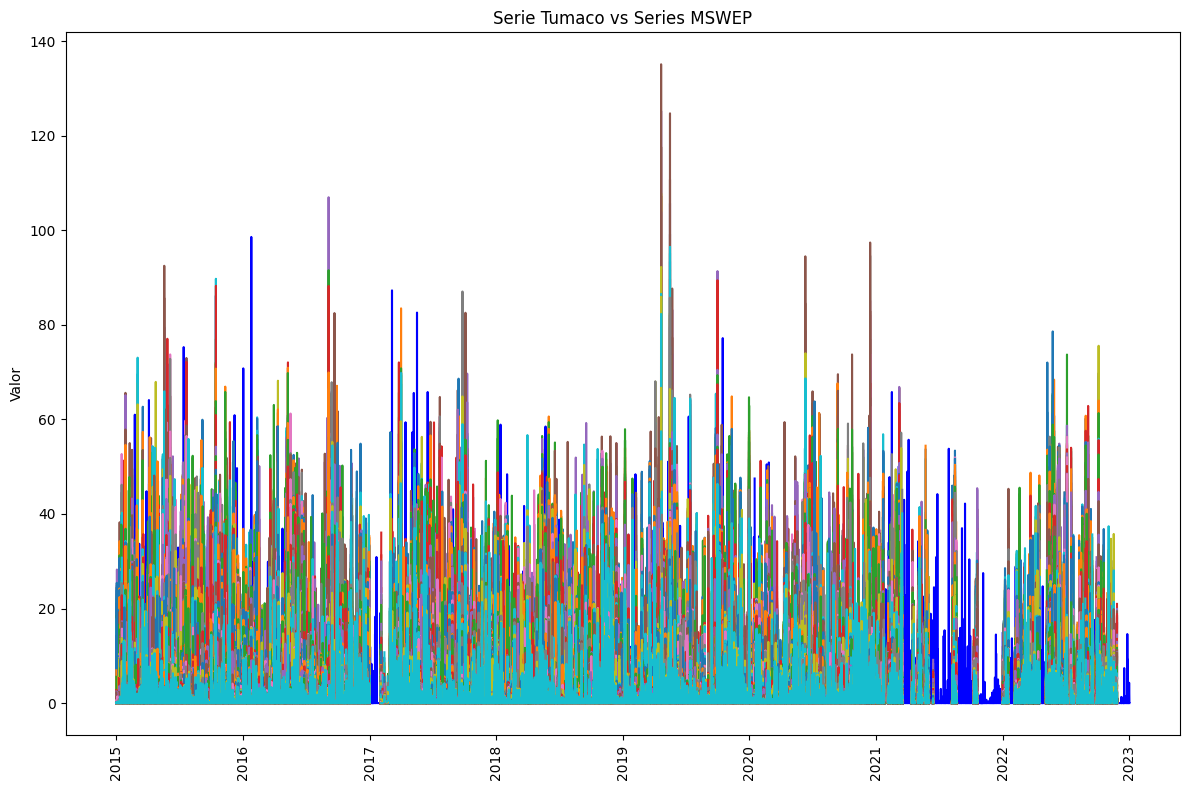

In [52]:
import matplotlib.pyplot as plt


# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(12, 8), sharex=True)

# Graficar la serie objetivo
ax.plot(filtered_iqr_dataset.index, filtered_iqr_dataset['value'], label="Tumaco", color="blue")

# Graficar todas las columnas de precipitación con colores automáticos
for col in precip_cols:
    ax.plot(filtered_iqr_dataset.index, filtered_iqr_dataset[col], label=col)

# Configurar título y etiquetas
ax.set_title('Serie Tumaco vs Series MSWEP')
ax.set_ylabel('Valor')
#ax.legend(loc='upper left')

# Ajustar diseño y mostrar
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()


In [53]:
precipNotNan = filtered_iqr_dataset.dropna()
print('Reporte de datos NaN por columna:')
print(precipNotNan.isnull().sum())
precipNotNan


Reporte de datos NaN por columna:
value                0
precipitation_1      0
precipitation_2      0
precipitation_3      0
precipitation_4      0
                    ..
precipitation_896    0
precipitation_897    0
precipitation_898    0
precipitation_899    0
precipitation_900    0
Length: 901, dtype: int64


value  precipitation_1  precipitation_2  precipitation_3  \
2015-01-01 00:00:00    0.0         1.000000         0.812500         0.437500   
2015-01-01 03:00:00    0.0         0.375000         0.437500         0.250000   
2015-01-01 06:00:00    0.0         0.250000         0.250000         0.687500   
2015-01-01 09:00:00    0.2         0.312500         0.062500         0.062500   
2015-01-01 12:00:00    4.7         0.750000         0.812500         0.812500   
...                    ...              ...              ...              ...   
2022-11-25 21:00:00    0.0         0.016920         0.019007         0.018900   
2022-11-26 03:00:00    0.0         0.019662         0.006580         0.006565   
2022-11-26 09:00:00    0.0         0.032139         0.042243         0.041898   
2022-11-26 12:00:00    0.0         0.016002         0.041127         0.040814   
2022-11-29 21:00:00    0.0         0.024004         0.039649         0.039328   

                     precipitation_4  precipitation_5  precipitation_6  \
2015-01-01 00:00:00         0.187500         0.187500         0.187500   
2015-01-01 03:00:00         0.687500         1.062500         1.250000   
2015-01-01 06:00:00         1.250000         1.250000         0.437500   
2015-01-01 09:00:00         0.000000         0.000000         0.000000   
2015-01-01 12:00:00         0.750000         0.750000         0.812500   
...                              ...              ...              ...   
2022-11-25 21:00:00         0.004469         0.004481         0.004517   
2022-11-26 03:00:00         0.005897         0.005918         0.005970   
2022-11-26 09:00:00         0.044485         0.044827         0.045546   
2022-11-26 12:00:00         0.084969         0.085854         0.087840   
2022-11-29 21:00:00         0.025691         0.025849         0.026143   

                     precipitation_7  precipitation_8  precipitation_9  ...  \
2015-01-01 00:00:00         0.187500         0.187500         0.187500  ...   
2015-01-01 03:00:00         1.500000         1.062500         0.812500  ...   
2015-01-01 06:00:00         0.750000         0.687500         0.687500  ...   
2015-01-01 09:00:00         0.000000         0.000000         0.000000  ...   
2015-01-01 12:00:00         0.875000         0.875000         0.812500  ...   
...                              ...              ...              ...  ...   
2022-11-25 21:00:00         0.005109         0.005087         0.005311  ...   
2022-11-26 03:00:00         0.015982         0.015835         0.001091  ...   
2022-11-26 09:00:00         0.025540         0.025246         0.014256  ...   
2022-11-26 12:00:00         0.143279         0.143912         0.139176  ...   
2022-11-29 21:00:00         0.055095         0.054176         0.018161  ...   

                     precipitation_891  precipitation_892  precipitation_893  \
2015-01-01 00:00:00           0.000000           0.000000           0.000000   
2015-01-01 03:00:00           0.000000           0.000000           0.000000   
2015-01-01 06:00:00           0.000000           0.000000           0.000000   
2015-01-01 09:00:00           0.000000           0.000000           0.000000   
2015-01-01 12:00:00           0.000000           0.000000           0.000000   
...                                ...                ...                ...   
2022-11-25 21:00:00           0.877691           0.628830           0.658874   
2022-11-26 03:00:00           0.028799           0.010813           0.010427   
2022-11-26 09:00:00           0.000124           0.012263           0.011733   
2022-11-26 12:00:00           0.002799           0.009658           0.008918   
2022-11-29 21:00:00           0.188982           0.087093           0.075255   

                     precipitation_894  precipitation_895  precipitation_896  \
2015-01-01 00:00:00           0.000000           0.000000           0.000000   
2015-01-01 03:00:00           0.000000           0.000000           0.000000   
2015-01-0

In [54]:
# Definir variables independientes (X) y dependiente (y)
xTrain = precipNotNan.drop(columns=['value'])
yTrain = precipNotNan['value'].values.flatten()
# Guardar columnas para usarlas después
columns_for_model = xTrain.columns

# Mostrar primeras 10 filas
print(xTrain.head(10))
print(yTrain[:10])

                     precipitation_1  precipitation_2  precipitation_3  \
2015-01-01 00:00:00           1.0000           0.8125           0.4375   
2015-01-01 03:00:00           0.3750           0.4375           0.2500   
2015-01-01 06:00:00           0.2500           0.2500           0.6875   
2015-01-01 09:00:00           0.3125           0.0625           0.0625   
2015-01-01 12:00:00           0.7500           0.8125           0.8125   
2015-01-01 15:00:00           0.1250           0.0000           0.0000   
2015-01-01 18:00:00           0.3125           0.0625           0.0000   
2015-01-01 21:00:00           0.6250           0.6875           0.6875   
2015-01-02 00:00:00           0.7500           0.3125           0.3125   
2015-01-02 03:00:00           0.8750           0.4375           0.4375   

                     precipitation_4  precipitation_5  precipitation_6  \
2015-01-01 00:00:00           0.1875           0.1875           0.1875   
2015-01-01 03:00:00           0.6875 

In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
import pandas as pd
import joblib

# Pipeline con RobustScaler (opcional para Random Forest)
pipeline = Pipeline([
    ('scaler', RobustScaler()),  # Aunque RF no requiere escalado, puede ayudar en algunos casos
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Grilla de hiperparámetros para Random Forest
param_grid = {
    'rf__n_estimators': [100, 200, 500],  # Número de árboles (evita valores altos por eficiencia)
    'rf__max_depth': [None, 10, 20, 40],  # Profundidad máxima (None para ilimitado)
    'rf__min_samples_split': [2, 5, 10, 50],  # Mínimo muestras para dividir un nodo
    'rf__min_samples_leaf': [1, 2],   # Mínimo muestras en hojas
    'rf__max_features': ['sqrt', 0.5]  # Features consideradas en cada split
}

# Validación cruzada temporal (TimeSeriesSplit)
cv = TimeSeriesSplit(n_splits=5)
scoring = {'R2':'r2', 'MAE': 'neg_mean_absolute_error', 'MSE': 'neg_mean_squared_error'}

# Configuración de GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=scoring,
    refit='R2',  # Métrica para seleccionar el mejor modelo
    cv=cv,
    n_jobs=1,  # Puedes aumentar si tienes múltiples núcleos
    verbose=2,
    return_train_score=True
)

# Ajustar el modelo
grid_search.fit(xTrain, yTrain)

# Resultados
print("\n✅ Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

best_rf = grid_search.best_estimator_.named_steps['rf']
print(f"\n🔍 Mejor score R² en validación cruzada: {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 192 candidates, totalling 960 fits
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   0.6s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   1.1s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   1.8s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   2.2s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=100; total time=   2.8s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_samples_split=2, rf__n_estimators=200; total time=   1.1s
[CV] END rf__max_depth=None, rf__max_features=sqrt, rf__min_samples_leaf=1, rf__min_s

In [56]:
# Mostrar tabla ordenada de resultados
results = pd.DataFrame(grid_search.cv_results_)

# Versión más robusta con manejo de errores
try:
    # Intentar con nombres estándar primero
    top_results = results.sort_values(by='mean_test_score', ascending=False)
    print(top_results[['mean_test_score', 'std_test_score', 'params']].head(5))
except KeyError:
    try:
        # Si falla, buscar columnas que contengan 'mean_test' y 'std_test'
        mean_col = [c for c in results.columns if 'mean_test' in c][0]
        std_col = [c for c in results.columns if 'std_test' in c][0]
        top_results = results.sort_values(by=mean_col, ascending=False)
        print(top_results[[mean_col, std_col, 'params']].head(5))
    except Exception as e:
        print(f"No se pudieron obtener los resultados: {str(e)}")
        print("Columnas disponibles:", results.columns.tolist())

# Guardar modelo
joblib.dump(grid_search.best_estimator_, 'best_rf_model_tum.pkl')

     mean_test_R2  std_test_R2  \
119      0.154128     0.022020   
71       0.153514     0.023267   
118      0.153231     0.022258   
70       0.152548     0.025175   
167      0.152384     0.024788   

                                                params  
119  {'rf__max_depth': 20, 'rf__max_features': 'sqr...  
71   {'rf__max_depth': 10, 'rf__max_features': 'sqr...  
118  {'rf__max_depth': 20, 'rf__max_features': 'sqr...  
70   {'rf__max_depth': 10, 'rf__max_features': 'sqr...  
167  {'rf__max_depth': 40, 'rf__max_features': 'sqr...  


['best_rf_model_tum.pkl']

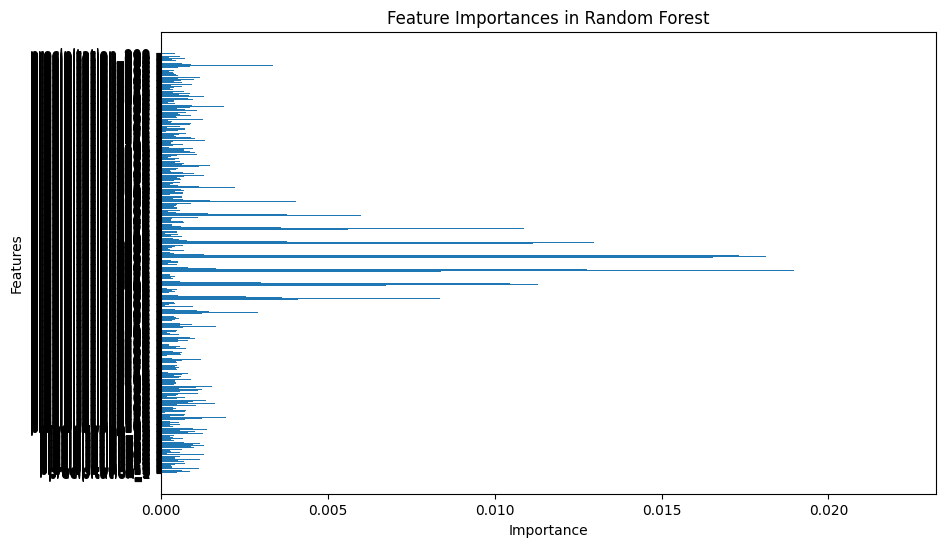

In [57]:
# Instead of trying to plot loss_curve_, you could:

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(best_rf.feature_importances_)), best_rf.feature_importances_)
plt.title("Feature Importances in Random Forest")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.yticks(np.arange(len(xTrain.columns)), xTrain.columns)
plt.show()

# Or if you want to see how performance changes with number of trees:
# (This would require re-running with warm_start=True)

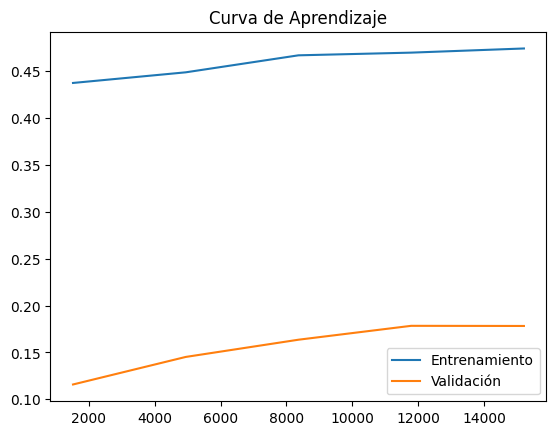

In [58]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_rf, xTrain, yTrain, cv=5
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Entrenamiento')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Validación')
plt.title("Curva de Aprendizaje")
plt.legend()
plt.show()

In [59]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Asumiendo que:
# - best_rf es tu RandomForestRegressor ya entrenado
# - X_train son tus características sin escalar (datos originales)
# - yTrain son tus valores objetivo

# Validación cruzada sin escalado
scores = cross_val_score(
    best_rf, 
    xTrain,  # Usamos los datos originales sin escalar
    yTrain, 
    scoring='neg_mean_squared_error', 
    cv=5
)

print("Cross-validation MSE scores:", -scores)
print("Cross-validation MSE promedio:", -scores.mean())
print("Desviación estándar:", np.std(-scores))

Cross-validation MSE scores: [17.23104014 12.46438432  9.97698086 15.53308156 10.07327304]
Cross-validation MSE promedio: 13.05575198531849
Desviación estándar: 2.908398908056676


- Guardar y reutilizar el modelo (opcional)

In [60]:
'''import joblib

# Guardar modelo
joblib.dump(regr, 'mlp_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Cargar luego
# regr = joblib.load('mlp_model.pkl')
'''

"import joblib\n\n# Guardar modelo\njoblib.dump(regr, 'mlp_model.pkl')\njoblib.dump(scaler, 'scaler.pkl')\n\n# Cargar luego\n# regr = joblib.load('mlp_model.pkl')\n"

In [61]:
# --- Predicción ---
yPredict = best_rf.predict(xTrain)
print(yPredict[:10])

e:\074-Diego Rengifo 2025\datasience\precipitacion\bigdata\bigdata\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning:

X has feature names, but RandomForestRegressor was fitted without feature names



[0.17151549 0.25206613 1.05787506 3.7217528  0.83828756 0.18154381
 0.05780949 0.06803941 0.18064853 0.53538022]


In [62]:
'''# --- Visualización de comparación ---
fig, ax = plt.subplots(figsize=(12, 8), sharex=True, sharey=True)
ax.plot(filtered_iqr_dataset.index, filtered_iqr_dataset['value'], label='Observado (Tumaco)', color='blue')
ax.plot(xTest.index, yPredict, label='Pronóstico (MLP)', color='red', linestyle='--')
ax.set_title('Comparación: Observado vs. Pronosticado')
ax.set_ylabel('Precipitación')
ax.legend()
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()'''

"# --- Visualización de comparación ---\nfig, ax = plt.subplots(figsize=(12, 8), sharex=True, sharey=True)\nax.plot(filtered_iqr_dataset.index, filtered_iqr_dataset['value'], label='Observado (Tumaco)', color='blue')\nax.plot(xTest.index, yPredict, label='Pronóstico (MLP)', color='red', linestyle='--')\nax.set_title('Comparación: Observado vs. Pronosticado')\nax.set_ylabel('Precipitación')\nax.legend()\nplt.xticks(rotation='vertical')\nplt.tight_layout()\nplt.show()"

C:\Users\drengifo\AppData\Local\Temp\ipykernel_54460\1114123481.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

e:\074-Diego Rengifo 2025\datasience\precipitacion\bigdata\bigdata\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning:

X has feature names, but RandomForestRegressor was fitted without feature names



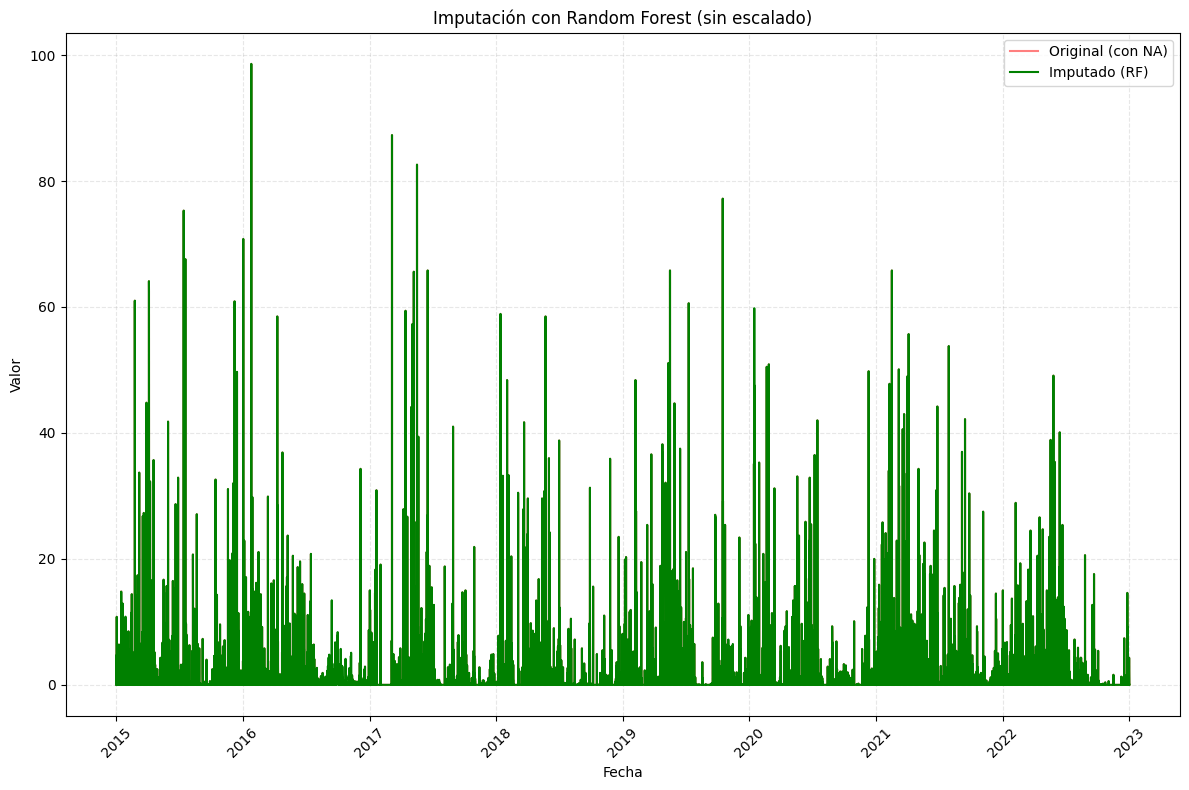


=== Resumen Estadístico ===
Total de registros: 23378
Valores originales disponibles: 22514
Valores imputados: 862
% de imputación: 3.69%

Comparación de distribuciones:
              value  imputados_rf
count  22514.000000  23376.000000
mean       0.807720      0.805961
std        3.926193      3.864370
min        0.000000      0.000000
25%        0.000000      0.000000
50%        0.000000      0.000000
75%        0.000000      0.095395
max       98.600000     98.600000


In [63]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Crear columna para valores imputados
filtered_iqr_dataset['imputados_rf'] = np.nan  # Usamos un nombre diferente para distinguir

## 2. Identificar valores faltantes a imputar
missing_mask = (
    filtered_iqr_dataset['value'].isna() & 
    filtered_iqr_dataset[columns_for_model].notna().all(axis=1)
)

## 3. Obtener datos para imputación (sin escalar)
to_impute = filtered_iqr_dataset.loc[missing_mask, columns_for_model]

## 4. Predecir con Random Forest (sin escalado)
predicted_values = best_rf.predict(to_impute)

## 5. Asegurar valores positivos si es necesario
predicted_values = np.maximum(predicted_values, 0)  # Más eficiente que np.where

## 6. Asignar valores imputados
filtered_iqr_dataset.loc[missing_mask, 'imputados_rf'] = predicted_values

## 7. Conservar valores originales
filtered_iqr_dataset.loc[filtered_iqr_dataset['value'].notna(), 'imputados_rf'] = \
    filtered_iqr_dataset['value']

## 8. Visualización comparativa
plt.figure(figsize=(12, 8))

# Serie original (con huecos)
plt.plot(filtered_iqr_dataset.index, filtered_iqr_dataset['value'], 
          color='red', alpha=0.5, label='Original (con NA)', markersize=3)

# Serie imputada
plt.plot(filtered_iqr_dataset.index, filtered_iqr_dataset['imputados_rf'], 
          color='green', linewidth=1.5, label='Imputado (RF)')

'''# Destacar puntos imputados
imputed_points = filtered_iqr_dataset[missing_mask]
plt.scatter(imputed_points.index, imputed_points['imputados_rf'], 
            color='lime', edgecolor='darkgreen', label='Puntos imputados', zorder=5)'''

plt.title('Imputación con Random Forest (sin escalado)')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 9. Análisis de resultados
print("\n=== Resumen Estadístico ===")
print(f"Total de registros: {len(filtered_iqr_dataset)}")
print(f"Valores originales disponibles: {filtered_iqr_dataset['value'].count()}")
print(f"Valores imputados: {missing_mask.sum()}")
print(f"% de imputación: {missing_mask.sum()/len(filtered_iqr_dataset)*100:.2f}%")

# Estadísticas descriptivas
print("\nComparación de distribuciones:")
print(filtered_iqr_dataset[['value', 'imputados_rf']].describe())

In [64]:
# Reporte de NaNs
print('Reporte de datos NaN por columna:')
print(filtered_iqr_dataset.isnull().sum())


Reporte de datos NaN por columna:
value                 864
precipitation_1      3504
precipitation_2      3504
precipitation_3      3504
precipitation_4      3504
                     ... 
precipitation_897    3504
precipitation_898    3504
precipitation_899    3504
precipitation_900    3504
imputados_rf            2
Length: 902, dtype: int64


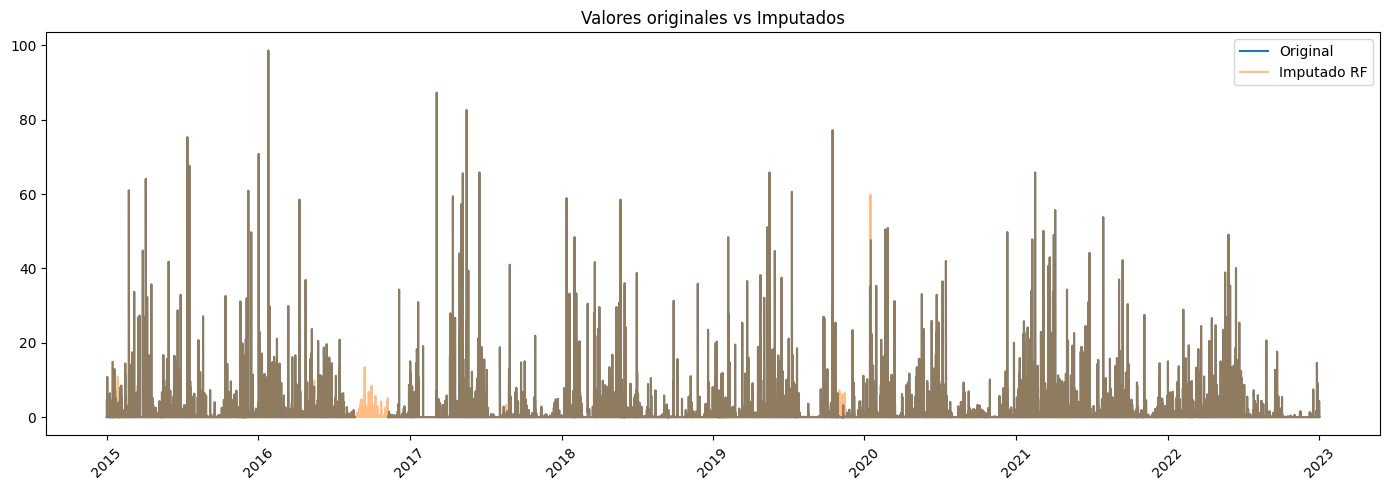

In [65]:
plt.figure(figsize=(14, 5))

# Líneas básicas
plt.plot(filtered_iqr_dataset['value'], label='Original')
plt.plot(filtered_iqr_dataset['imputados_rf'], alpha=0.5, label='Imputado RF')

# Formateo simple
plt.title('Valores originales vs Imputados')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [66]:
from graphics_utils.go import multi_line

fig=multi_line(original=filtered_iqr_dataset['value'], imputada=filtered_iqr_dataset['imputados_rf'])
fig.show()

# validacion de pronostico 2023

In [67]:
# --- Predicción ---
yPredict = best_mlp.predict(X_train_scaled)
print(yPredict[:10])

# 1. Valores originales sin escalar (serie completa hasta 2023)
# Debe tener frecuencia fija de 3H y estar limpia
# Asegúrate de que el índice sea de tipo datetime
msweb_serie_with_nans.index = pd.to_datetime(msweb_serie_with_nans.index)
xTrainScaledForecast = msweb_serie_with_nans.loc['2023']  # serie original sin escalar

# 2. Últimos N valores de la serie para generar los primeros lags
N_LAGS = X_train_scaled.shape[1]  # número de columnas usadas como input
últimos_valores = precip_series.dropna().values[-N_LAGS:].tolist()

# 3. Crear fechas objetivo del forecast
n_horas = int((365 * 24) / 3)  # para 3 horas: 2920 pasos
fechas_2024 = pd.date_range(start='2023-01-01', periods=n_horas, freq='3H')

# 4. Forecast recursivo
predicciones = []

for _ in range(n_horas):
    # Tomar los últimos N valores
    input_vals = np.array(últimos_valores[-N_LAGS:]).reshape(1, -1)
    
    # Escalar
    input_scaled = best_scaler.transform(input_vals)
    
    # Predecir
    y_pred = best_mlp.predict(input_scaled)[0]
    
    # Guardar predicción
    predicciones.append(y_pred)
    
    # Añadir al historial para la siguiente predicción
    últimos_valores.append(y_pred)  # usamos el valor predicho como siguiente lag


NameError: name 'best_mlp' is not defined

In [ ]:
pred_2024 = pd.DataFrame({'Predicción': predicciones}, index=fechas_2024)
pred_2024.index = pd.to_datetime(pred_2024.index)

# Crear gráfico
plt.figure(figsize=(12, 6))
plt.plot(pred_2024.index, pred_2024['Predicción'], label='Predicción 2024', color='royalblue')

# Formato del gráfico
plt.title('Predicción de Precipitación para el Año 2024')
plt.xlabel('Fecha')
plt.ylabel('Precipitación (mm)')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Mostrar gráfico
plt.show()



NameError: name 'predicciones' is not defined

¿Valores nulos restantes? 0


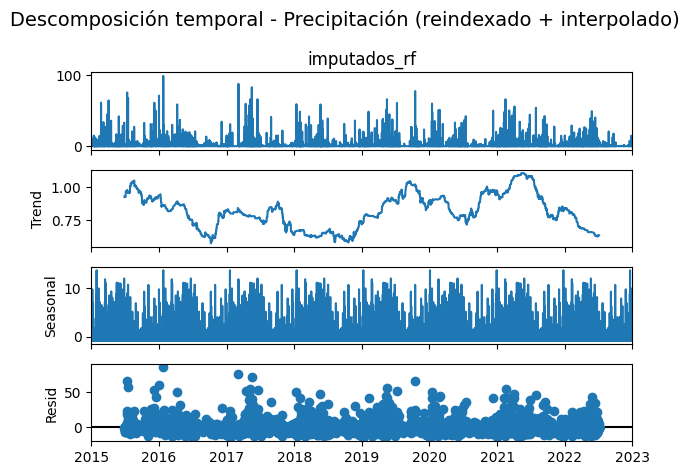

In [68]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# 1. Selecciona la columna
precip_clean = filtered_iqr_dataset['imputados_rf'].copy()

# 2. Convierte el índice a datetime si no lo es
precip_clean.index = pd.to_datetime(precip_clean.index)

# 3. Reindexar con frecuencia completa para evitar huecos ocultos
full_index = pd.date_range(start=precip_clean.index.min(), end=precip_clean.index.max(), freq='3h')
precip_clean = precip_clean.reindex(full_index)

# 4. Interpola para evitar NaNs
precip_clean = precip_clean.interpolate(method='linear')

# 5. Confirmar limpieza
print("¿Valores nulos restantes?", precip_clean.isna().sum())

# 6. Descomposición (usamos period=8 para ciclo diario en datos 3H)
decomposition = seasonal_decompose(precip_clean, model='additive', period=8*30*12)
decomposition.plot()
plt.suptitle("Descomposición temporal - Precipitación (reindexado + interpolado)", fontsize=14)
plt.tight_layout()
plt.show()


In [69]:
from statsmodels.tsa.seasonal import seasonal_decompose
import pandas as pd
import plotly.graph_objects as go

# 1. Selección de la columna
precip_clean = filtered_iqr_dataset['imputados_rf'].copy()

# 2. Conversión del índice a datetime
precip_clean.index = pd.to_datetime(precip_clean.index)

# 3. Reindexar con frecuencia completa
full_index = pd.date_range(start=precip_clean.index.min(), end=precip_clean.index.max(), freq='3h')
precip_clean = precip_clean.reindex(full_index)

# 4. Interpolación para NaNs
precip_clean = precip_clean.interpolate(method='linear')

# 5. Verificar valores nulos
print("¿Valores nulos restantes?", precip_clean.isna().sum())

# 6. Descomposición
decomposition = seasonal_decompose(precip_clean, model='additive', two_sided=True,period=8*28*18)

# 7. Visualización con Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=precip_clean.index, y=decomposition.observed, name='Observed'))
fig.add_trace(go.Scatter(x=precip_clean.index, y=decomposition.trend, name='Trend'))
fig.add_trace(go.Scatter(x=precip_clean.index, y=decomposition.seasonal, name='Seasonal'))
fig.add_trace(go.Scatter(x=precip_clean.index, y=decomposition.resid, name='Residual'))

fig.update_layout(
    title='Descomposición Temporal - Precipitación (Plotly)',
    xaxis_title='Fecha',
    yaxis_title='Valor',
    height=600,
    legend_title='Componentes',
    template='plotly_white'
)

fig.show()


¿Valores nulos restantes? 0
